In [1]:
import pandas as pd
import numpy as np

from numpy.random import seed
seed(30)
df = pd.read_pickle(r'./combined_data_feb2023.pkl')

In [2]:
features = ['Ward Glucose', 'Haemoglobin',
       'Mean cell volume, blood', 'White blood cell count, blood',
       'Haematocrit', 'Platelets', 'Urea level, blood', 'Creatinine', 'Sodium',
       'Potassium', 'Lymphocytes', 'Neutrophils', 'C-Reactive Protein',
       'Eosinophils', 'Alkaline Phosphatase', 'Albumin',
       'Alanine Transaminase', 'Bilirubin', 'Total Protein',
       'Fibrinogen (clauss)', 'Glucose POCT Strip Blood', 'Ferritin',
       'D-Dimer', 'Ward Lactate', 'age', 'sex', 'SARS CoV-2 RNA']



In [3]:
#Manual split of training, validation and test set, and displays of their properties

start_date = '2014-1-1'
train_date = '2020-12-1'
val_date = '2021-03-1'

train = df[(df['date_culture']>=start_date)&(df['date_culture']<train_date)]

val = df[(df['date_culture']>=train_date)&(df['date_culture']<val_date)]

test = df[df['date_culture']>=val_date]

display('Train')
display(train['pathogenic'].value_counts(normalize=True))
display(len(train.groupby(['id','date_culture'])))

display('Val')
display(val['pathogenic'].value_counts(normalize=True))
display(len(val.groupby(['id','date_culture'])))

display('Test')
display(test['pathogenic'].value_counts(normalize=True))
display(len(test.groupby(['id','date_culture'])))

'Train'
pathogenic
0.0    0.761944
1.0    0.238056
Name: proportion, dtype: float64

13354
'Val'
pathogenic
0.0    0.885361
1.0    0.114639
Name: proportion, dtype: float64
1858
'Test'
pathogenic
0.0    0.915928
1.0    0.084072
Name: proportion, dtype: float64

5638

In [5]:
def scale_data(train_data, val_data, test_data, feature_list):
    
    from sklearn.preprocessing import MinMaxScaler
    scale = MinMaxScaler(feature_range=(-1,1))
    
    train_scaled=train_data.copy()
    train_scaled[feature_list] = scale.fit_transform(train_scaled[feature_list])
    
    val_scaled = val_data.copy()
    val_scaled[feature_list]=scale.transform(val_scaled[feature_list])

    test_scaled = test_data.copy()
    test_scaled[feature_list] = scale.transform(test_scaled[feature_list])

    return train_scaled, val_scaled, test_scaled


In [6]:

train_scaled, val_scaled, test_scaled = scale_data(train, val, test, features)

#Fillna(0) done after scaling for masking layer
train_scaled = train_scaled.fillna(0)
val_scaled = val_scaled.fillna(0)
test_scaled = test_scaled.fillna(0)


In [7]:
# Shuffled ordering of the time series sequences through using np.sample
# Models are trained against unshuffled versions and evaluated against shuffled hold out test sets below

train_scaled_shuffled = train_scaled.groupby(['id']).sample(n=15)
test_scaled_shuffled = test_scaled.groupby(['id']).sample(n=15)
val_scaled_shuffled = val_scaled.groupby(['id']).sample(n=15)

In [8]:
# Reshape function takes features listed above and slices them into train, test sets and reshapes to (samples,steps,features)

def reshape(data):
    data_samples = len(data.groupby('id'))
    data_steps = len(data)/ len(data.groupby(['id']))
    data_steps = int(data_steps)
    data_feature_size = len(data[features].columns)

    data_features = data[features].fillna(0).values.reshape(data_samples,data_steps,data_feature_size)
    y_data = data.groupby(['id'])['pathogenic'].max().astype(int).values 

    return data_features, y_data

X_train, y_train = reshape(train_scaled)
X_val, y_val = reshape(val_scaled)
X_test, y_test = reshape(test_scaled)

In [9]:
X_train_shuffled, y_train_shuffled = reshape(train_scaled_shuffled)
X_test_shuffled, y_test_shuffled = reshape(test_scaled_shuffled)
X_val_shuffled, y_val_shuffled = reshape(val_scaled_shuffled)

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import LSTM
from keras import regularizers
from keras.layers import BatchNormalization
import tensorflow as tf

model_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)
    ]

model = Sequential()
model.add(tf.keras.layers.Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(100))
model.add(Dense(1, activation= 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(from_logits=True, name='auc')])



2023-09-26 15:38:07.769845: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 15:38:08.596082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-26 15:38:09.623343: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
history = model.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=300, batch_size=256, callbacks=model_callbacks)

Epoch 1/300
53/53 [==============================] - 16s 165ms/step - loss: 0.3259 - auc: 0.9020 - val_loss: 0.5373 - val_auc: 0.9194
Epoch 2/300
53/53 [==============================] - 6s 119ms/step - loss: 0.2772 - auc: 0.9253 - val_loss: 0.4254 - val_auc: 0.9078
Epoch 3/300
53/53 [==============================] - 6s 120ms/step - loss: 0.2672 - auc: 0.9324 - val_loss: 0.3116 - val_auc: 0.9181
Epoch 4/300
53/53 [==============================] - 6s 120ms/step - loss: 0.2630 - auc: 0.9351 - val_loss: 0.2780 - val_auc: 0.9297
Epoch 5/300
53/53 [==============================] - 6s 120ms/step - loss: 0.2589 - auc: 0.9375 - val_loss: 0.2303 - val_auc: 0.9332
Epoch 6/300
53/53 [==============================] - 6s 120ms/step - loss: 0.2542 - auc: 0.9401 - val_loss: 0.2091 - val_auc: 0.9351

In [12]:
# Two predictions are made: X_test which is the original hold out test set, and X_test_shuffled which is the shuffled test set
predictions = model.predict(X_test)
predictions_shuffled = model.predict(X_test_shuffled)


177/177 [==============================] - 1s 7ms/step


In [13]:
from functions.tools import metrics

Best Threshold=0.041515
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      5164
           1       0.56      0.99      0.71       474

    accuracy                           0.93      5638
   macro avg       0.78      0.96      0.84      5638
weighted avg       0.96      0.93      0.94      5638

Specificity 0.9281564678543764
Sensitivity 0.9915611814345991
ROC score 0.9730293626436839
AP 0.6838534438626335
PPV 0.558858501783591
NPV 0.999166145507609
BS 0.037505692199131135
AUPRC 0.6838534438626335


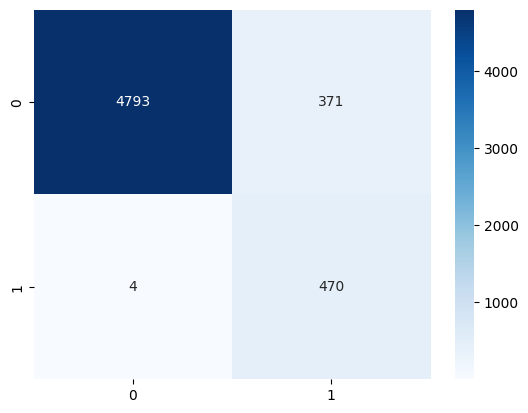

In [14]:
metrics(predictions, y_test)

Best Threshold=0.035303
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5164
           1       0.55      0.67      0.60       474

    accuracy                           0.93      5638
   macro avg       0.76      0.81      0.78      5638
weighted avg       0.93      0.93      0.93      5638

Specificity 0.9494577846630519
Sensitivity 0.6708860759493671
ROC score 0.8373742102906523
AP 0.46350598690609146
PPV 0.5492227979274611
NPV 0.9691638663767543
BS 0.05723442192356101
AUPRC 0.46350598690609146


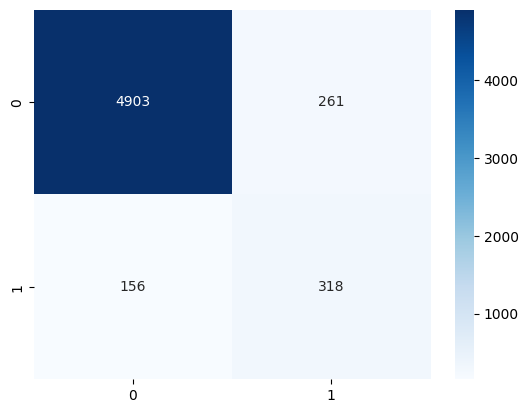

In [15]:
metrics(predictions_shuffled, y_test_shuffled)

In [16]:
#This bootstraps the hold out set results for the shuffled test set
from functions.bootstrap import *

print('summarised')
score, ci_lower, ci_upper, scores = score_ci(y_test_shuffled, list(predictions_shuffled.reshape(predictions.shape[0])), score_fun=rc)
print('auroc')
print(round(score,2),'(',round(ci_lower,2),'-',round(ci_upper,2),')')
score, ci_lower, ci_upper, scores = score_ci(y_test_shuffled, list(predictions_shuffled.reshape(predictions.shape[0])), score_fun=ap)
print('auprc')
print(round(score,2),'(',round(ci_lower,2),'-',round(ci_upper,2),')') 

summarised
auroc
0.84 ( 0.82 - 0.86 )
auprc
0.46 ( 0.41 - 0.52 )
